# Predicting cancerous mutations from images of human cells

## Goals

In previous cases we learned the fundamentals of an artificial neural network (ANN) and saw how powerful they could be in analyzing complex data, especially large datasets with highly nonlinear relationships. 

However, we were still working with traditional data composed of structured feature vectors. In this case, you will learn about a particular type of neural network architecture, the **convolutional neural network**, which can handle more complex data, like images. You will learn not only the structure of this kind of model but also how to train and evaluate it using a modern data science toolbox. You will also be able to assess your CNN's strengths and limitations in comparison to simpler models and gain experience with TensorFlow and Keras.

In [1]:
### Load relevant packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# general
from numpy import mean
from numpy import std
from scipy.stats import truncnorm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix

# image processing
from PIL import (
    Image,
)  # <-- if you cannot install, comment out and find the cell containing %%help%%

# import pickle  # <-- these packages are optional, only if you want to explore image processing
# import glob
# import os

# convolutional neural network
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD

# random forest
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

%matplotlib inline
plt.style.use("ggplot")

C:\ProgramData\Anaconda3\envs\DS4A\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\envs\DS4A\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\envs\DS4A\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaconda3\envs\DS4A\lib\site-packages\tensorflow\python\frame

## Introduction

<img src=files/hook.jpg width="500">

**Business Context.** You work for a medical research group working to develop a diagnostic method that identifies an individual’s **predisposition to cancer** based on images of human cells. 

This tool could be revolutionary for identifying specific mutations on the cancer-associated p53 gene without genetic testing - the procedure could be a lot cheaper and less invasive. Additionally, if we understand what features of the images are being used to distinguish the mutant cells, this could help generate further hypotheses and experiments for underlying biological differences to help determine a person's predisposition. 

There are three different kinds of mutations you want to be able to detect, based on hundreds of images of cells photographed under a microscope. You also need to be able to detect whether there is a mutation at all.

**Business Problem.** You have been tasked with **predicting the mutation of a cell, given any information you can obtain from these photographs**. Specifically, you will be using both raw images of human fibroblast cells and features extracted from these images using image processing algorithms.

**Analytical Context.** In the last case, you became familiar with basic neural networks by predicting the fair market value of used cars. The dataset you used was some of the standard structured data you have probably seen before: features scraped from Craigslist. In this case, you will be working with image data and learn about more advanced neural networks: in particular, the **convolutional neural network** (CNN). You will practice using and comparing a range of machine learning classifiers, both traditional and more modern, in order to tackle the question: *Can we predict cancerous mutations from images of human cells?*

The case is structured as follows: (1) you will understand the raw image dataset; (2) you will build, train, and evaluate a simple CNN from scratch; (3) you will build, train, and evaluate a more complex CNN using TensorFlow's `keras` module; and (4) you will build, train, and evaluate a more traditional machine learning classifier (random forest) on a set of features pre-extracted from the raw images.

<img src=files/cellimage.jpg width="500">

In the image above, you can see a photograph of human lung fibroblast cells under a microscope. The green is the body (the cytoplasm) of the cell and the pink is the nucleus. Biotechnology has advanced so that we can actually "color" cells and photograph them with high-definition microscopes. We can also do this at large scales, photographing thousands of cells at a time. Nowadays, scientists can even color different parts of a cell (such as the nucleus above, but also other organelles) by making different proteins light up with photofluorescence. As in many other industries, this has led to an explosion of data, because every cell now has countless features we could observe from a single image.

What we will explore in this case is how to work with this image data. However, many of the challenges we will face in this case are ones not unique to the problem of understanding cells - they are helpful if you ever need to work with image data.

## Understanding the data

### Preprocessing the images

Take a look at an example of a raw image from each class in greyscale (they were originally in color). The first image is of a cell with the first mutation (the photographs of cells are enhanced to refine edges and decrease blurring). The next image is an example of a cell with the second mutation. Then there is an example of a cell with the third mutation, which is fainter because they come from a lab that does not do image enhancements. Finally, there is an example of a cell where there are no mutations. These samples come from a lab where the cell borders are circled manually by a technician.

Note the use of [plt.subplot](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) to show several images in the same plot.

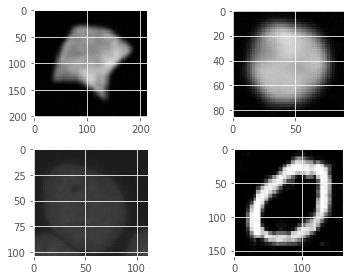

In [2]:
# %%help%% If you are having trouble installing PIL, you can just open the images
# in the sample_images directory to view them, instead of running this code.

sample_images_path = "sample_images/"
sample_images_list = ["mut_1", "mut_2", "mut_3", "normal"]
for i, img in zip(range(len(sample_images_list)), sample_images_list):
    pil_im = Image.open(sample_images_path + img + ".png", "r")
    # plot raw pixel data,
    plt.subplot(2, 2, 1 + i)
    plt.imshow(np.asarray(pil_im), cmap="Greys")
plt.tight_layout()
plt.show()

In the interest of time, we will be working with a preprocessed dataset of the images. The code block below shows some of the transformations that were performed on the raw PNG files. As this has already been run, you don't need to run this code again, and it is "gated" behind an `if False` statement.

Notice that we resized, centered, and scaled the images and also adjusted for some contrast differences, but we did not adjust for blur. Try to think about what the implications might be for some of these decisions:

In [3]:
## function to resize image, preserving aspect ratio

run_preprocessing = False
if run_preprocessing:

    def resizeAspect(im, size):
        w, h = im.size
        aspect = max(size[0] / float(w), size[1] / float(h))
        return im.resize((int(w * aspect), int(h * aspect)), Image.ANTIALIAS)

    data_path = "raw_images/"
    imgList = glob.glob(data_path + "*.png")  # find all png images in a directory

    num = 0
    for img in imgList:  # loop through all found images
        im = Image.open(img)  # open the image
        print("resizing:", os.path.basename(img))
        w, h = im.size  # get image width and height
        if min(w, h) > 28:  # check if either dimension is greater then 50
            im = resizeAspect(im, (28, 28))  # re-size image
            w, h = im.size  # update image size
        center = [int(w / 2.0), int(h / 2.0)]  # calculate center
        box = (
            center[0] - 14,
            center[1] - 14,
            center[0] + 14,
            center[1] + 14,
        )  # defines a box where you want it to be cropped
        croppedIm = im.crop(box)  # crop the image
        # croppedIm.show()                           # show the cropped image
        print(croppedIm.size)
        fileName, fileExtension = os.path.splitext(img)
        croppedIm.save(
            "images/" + fileName[len(data_path) :] + "_crop.png", "PNG"
        )  # save the cropped image

### Images in CSV files

After all the preprocessing is complete, we can load in our image data via a CSV file and take a look at our adjusted images. All the dimensions are the same and some of the differences in contrast have been fixed.

If you're used to dealing with images as single files (e.g. `.png` files), it might seem strange to think of storing images in a `.csv` file. The concept behind this is simple though. Each of our images is made up of 28x28 pixels, which is 784 pixels in total. Each image in `data/all_dat.csv` is represented by a row with 785 columns
   
The first column is the classification label for each image. Specifically, this is `0` for "normal" cells and `1`, `2`, or `3` for mutation types 1, 2, and 3 respectively. The next 784 columns represent the greyscale value (lower values are darker) of each pixel. We therefore have 1200 samples (rows) with 784 columns each.


In [4]:
# look at the dimensions of our data
all_dat = np.asfarray(pd.read_csv("data/all_dat.csv"))

# the first column is the labels
all_imgs = np.asfarray(all_dat[:, 1:])
all_labels = np.asfarray(all_dat[:, :1])

print(all_imgs.shape)
print(all_labels.shape)

(1200, 784)
(1200, 1)


In [5]:
# Look at our first few samples
pd.DataFrame(all_imgs).head()

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,...,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922
1,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,...,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922
2,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,...,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922
3,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,...,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922
4,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,...,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922,-0.003922


### Plotting images from the CSV file

Because each image is stored on a single row, if we want to actually view them as images instead of text we need to "reshape" them to a 28x28 2D array and specify that they are defined as greyscale pixels.
    
An example of displaying a single image is as follows:

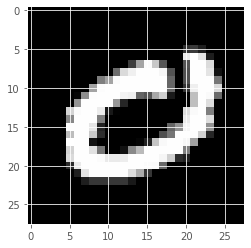

In [6]:
# reshape to 28x28 pixels
img = all_imgs[0].reshape((28,28))

# display the image, mapping each pixel value to a "greys" colour scale
plt.imshow(img, cmap="Greys")
plt.show()

### Exercise 1:

Plot a grid of images with four rows, one for each type of sample. In each row, display a random sample from the CSV dataset of cells with that type of mutation.

**Answer.**

In [ ]:
for i in range(1,9):
    plt.subplot(4,4,i)
    rowToPlot = np.random.choice()

----------

This should give you an intuitive understanding of what the machine learning algorithm needs to learn so that it can distinguish between the different types of cells. Even as a non-expert, we can see that the mutation types seem fairly distinct from each other, so it should not be too difficult for a classifier to tell them apart.


### Preprocessing the data

Before we get started with building our models, we want to split the dataset into a train and test set, and one-hot encode the labels.

### Exercise 2:

Split the dataset such that 90% of the data is used for training and 10% of the data is reserved for testing. You should further "stratify" the data so that the same proportion of each type of cell is present in the training and test sets.

**Hint:** You can pass `stratify` to sklearn's [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function via a one-hot coding representation:
        
```
label 0 in one-hot representation: [1 0 0 0]
label 1 in one-hot representation: [0 1 0 0]
label 2 in one-hot representation: [0 0 1 0]
label 3 in one-hot representation: [0 0 0 1]
```

**Answer.**

----------

## Building and training a neural network from scratch



Let's now build a simple single-layer, single-epoch neural network from scratch (using only `numpy` and `scikit-learn`) and train it using the raw images. In the previous case, recall that we used the [`Sequential`](https://keras.io/guides/sequential_model/) functionality from [`keras`](https://keras.io/)). We will be using more out-of-the-box tools later in this case, but to make sure you understand how neural networks work it's good to build a simple one yourself.

We will be constructing a very basic neural network from scratch in the `NeuralNetwork` class. You can find some skeleton code for this class below.



```
class NeuralNetwork:
    
    def __init__(self, 
                 no_of_in_nodes, 
                 no_of_out_nodes, 
                 no_of_hidden_nodes,
                 learning_rate):
        self.no_of_in_nodes = no_of_in_nodes
        self.no_of_out_nodes = no_of_out_nodes
        self.no_of_hidden_nodes = no_of_hidden_nodes
        self.learning_rate = learning_rate 
        self.create_weight_matrices()
        
    def create_weight_matrices(self):
        ...
        
    def train(self, input_vector, target_vector):
        ...
        
    def run(self, input_vector):
        return ...
            
    def confusion_matrix(self, data_array, labels):
        return ...
    
    def evaluate(self, data, labels):
        return ...
```



We will also be adding the functions `precision` and `recall` for convenience.

For fully connected neural networks, there are three essential questions that define the network's **architecture**:

1. How many layers are there?
1. How many nodes are there in each of those layers?
1. What activation function is used at each of those layers?

Remember that there is an activation function (usually the logistic regression function) between each pair of layers, which allows our network to develop non-linear sensitivities. When there are multiple layers, we can keep adding more linear combinations of the nodes, which will lead to more complex non-linear models. We already saw the simple non-linear activation function *ReLu*. In this case, we will also be using the *sigmoid function* as an activation function, but the key thing to remember is that there are [many different activation functions](https://www.analyticsvidhya.com/blog/2020/01/fundamentals-deep-learning-activation-functions-when-to-use-them/) and your problem's structure and constraints will guide you regarding which one is best to use. For example, the image classification task at hand makes the ReLU a good option for us due to its efficiency.

### Exercise 3:

Write the `sigmoid` and `relu` activation functions. Some skeleton code is shown below.

```
def sigmoid(x):
    """
    Sigmoid function (decays exponentially at the tails).
    """
    return ???

def relu(x):
    """
    Rectified linear unit function (negative elements set exactly to zero).
    """
    return ???
```

**Answer.**

----------

Notice the `@` symbol in the solution - this signals that the function that follows is a Python decorator, which can make function changes easier to implement and more readable. You can learn more [here](https://stackoverflow.com/questions/19844177/what-does-the-symbol-do-in-ipython-python). Now, let's plot the activation functions so we can examine their differences visually. The ReLu function should look familiar to you:

In [ ]:
def plot_activation_function(activation_function):
    """
    Plots the given activation_function
    for the domain (-10, 10).
    """
    # define a series of inputs
    series_in = [x for x in range(-10, 11)]
    # calculate outputs for our inputs
    series_out = [activation_function(x) for x in series_in]
    # line plot of raw inputs to rectified outputs
    plt.plot(series_in, series_out)
    plt.show()
    
plot_activation_function(sigmoid)
plot_activation_function(relu)

A crucial part of our `NeuralNetwork` class are the network parameters, the `weight_matrices`. Our `train` function must learn what the contents of these weight matrices are, and the `run` function will then apply those weights to new input (e.g. test data). If you are mathematically inclined, here is some notation to help you understand how the values of nodes are updated with weights and activation functions.

At layer $\ell$ in the network, for $\ell = 1, \ldots, L$, define:

* $n_\ell$ as the number of nodes in the layer
* $W_\ell$ as the weight matrix
* $W_{\ell,jk}$ as the weight from node $j$ in layer $\ell-1$ to node $k$ in layer $\ell$
* $a_\ell$ as the activation vector, where $a_{\ell,j}$ is the activation produced by node $j$ in layer $\ell$
* $a_0$ is the input vector
* $b_\ell$ is the bias 

We will denote $z_\ell = W_\ell^T a_{\ell-1} + b_\ell$ for convenience. In a neural network, we have the following recurrence relation:

$$a_\ell = \phi(W_\ell^T a_{\ell-1} + b_\ell) = \phi(z_\ell),$$

$$a_0 = x,$$

for layers $\ell = 1, \ldots, L$. 

ie: The activation $a_\ell$ at layer $\ell$ is the sum of the dot product of the weights with the activations of the previous layer $a_{\ell-1}$ and the bias parameter. 

This will assist you later in filling in gaps in the skeleton code. Note that the bias parameter can be ignored for simplicity. You can read more on them [here](https://medium.com/deeper-learning/glossary-of-deep-learning-bias-cf49d9c895e2).)

### Exercise 4:

By now, you should have most of the pieces you need to build your own neural network from scratch. Attempt to fill out the skeleton code for `class NeuralNetwork` provided earlier. If you need help, refer to the examples given [here](https://www.python-course.eu/neural_network_mnist.php).

**Answer.**

----------

## Using the neural network that we built from scratch

Now that we have our own `NeuralNetwork` class, it's time to try it out on our problem.

### Exercise 5:

#### 5.1

Create an instance of the network, train it on the training dataset (showing it each training example only once), and get it to predict the label for each of the first 10 examples in the test dataset as well as the confidence of the prediction. Use appropriate values for the learning rate and number of hidden nodes based on your experience in previous cases.

**Answer.**

----------

#### 5.2

Now evaluate the network on the train and test datasets and print out a confusion matrix. Describe your results.

**Answer.**

----------

#### 5.3

As you know from previous cases, neural networks benefit from seeing examples more than once over several epochs. Train the network again, but this time for 30 epochs, and see if the results are better. Once again, describe your results.

**Hint:** The neural network we built doesn't have epoch functionality built in but you can run a simple `for` loop to show it the dataset many times. You should output the train and test accuracy after every epoch.

**Answer.**

----------

## Building and training a convolutional neural network

There are many factors that can contribute to the performance of a neural network. As discussed in previouos cases, these include which loss function is used (we will use [**categorical crossentropy**](https://keras.io/api/losses/probabilistic_losses/#categoricalcrossentropy-class)), which optimization algorithm is used (we will use [**stochastic gradient descent**](https://keras.io/api/optimizers/sgd/)), how many training epochs to run before stopping, and the batch size within each epoch. The performance is also influenced by the number of hidden layers.

Regular neural networks may not scale well to full images. In our dataset of cells, images were originally of size 200x200x3 (200 wide, 200 high, 3 RGB color channels), so a single fully-connected neuron in the first hidden layer of a regular neural network would have 200x200x3 = 120,000 weights. This is unmanageable; moreover, we would want to have more than just a single neuron in our network. This huge number of parameters would lead to overfitting, which is why we scaled down the images to 28x28x1 to make a fully-connected structure feasible. Recall that we also flattened our input images to a single vector of length 784. This is not ideal as we obfuscate information about which pixels are next to each other.

### Understanding Convolutional Neural Networks

**Convolutional neural networks (CNN)** take advantage of the fact that the input consists of images, whose spatial properties naturally constrain the architecture to keep the number of parameters manageable. In particular, unlike a regular neural network, the layers of a CNN have neurons arranged in 3 dimensions: width, height, and depth. (Note that the word depth here does not refer to the total number of layers in a network.) For example, our original input images were of dimensions 200x200x3 (width, height, depth respectively), where the depth refers to the 3 RGB color channels. The neurons in a layer will only be connected to a small region of the layer before it, instead of all of the neurons. Graphically, CNNs are commonly represented by rectangular prisms to show that the neurons are arranged in 3 dimensions:

<img src=files/ann_v_cnn.png width="800">

On the left, we have a regular 3-layer neural network. On the right, we have a convolutional neural network. A CNN arranges its neurons in three dimensions (width, height, depth) as visualized in one of the layers. Every layer of a CNN transforms the 3D input volume to a 3D output volume of neuron activations. In this example, the red input layer holds the image, so its width and height would be the dimensions of the image, and the depth would be 3 (e.g. red, green, blue channels if using standard RGB-encoded color images).

Now that we have seen the implementation of a simple fully-connected neural network, we can build a more advanced network using an existing software package. We will use the built-in `Sequential` functionality of Python's `keras` library to build a more advanced network.

In order to determine the right hyperparameters for our neural network, we will need to rerun our neural network with different parameters multiple times. It is helpful if we set up a model pipeline to make this process easier. Here, we create `load_dataset` and `prep_pixels` functions to make it easy to load and prepare the data we need for training:

In [ ]:
# load train and test dataset
def load_dataset():
    # load dataset
    all_dat = np.asfarray(pd.read_csv("data/all_dat.csv"))
    # the first column is the labels
    all_imgs = np.asfarray(all_dat[:, 1:])
    all_labels = np.asfarray(all_dat[:, :1])

    # split into train:test
    trainX, testX, trainY, testY = train_test_split(
        all_imgs, all_labels, test_size=0.1, stratify=all_labels, random_state=13
    )
    # reshape dataset to have a single channel
    trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
    testX = testX.reshape((testX.shape[0], 28, 28, 1))
    # one hot encode target values
    trainY = to_categorical(trainY)
    testY = to_categorical(testY)
    return trainX, trainY, testX, testY


# scale pixels
def prep_pixels(train, test):
    # convert from integers to floats
    train_norm = train.astype("float32")
    test_norm = test.astype("float32")
    # normalize to range 0-1
    train_norm = train_norm / 255.0
    test_norm = test_norm / 255.0
    # return normalized images
    return train_norm, test_norm

Before we begin defining our neural network architecture, be sure you are familiar with these key terms and parameters. You should be familiar with a few of them from the previous case:

1. **optimizer**: The optimization algorithm used to update weights in neural network training. A common optimizer is stochastic gradient descent (SGD).
1. **learning rate**:Tthe influence of the gradient in updating the weights of the neural network at each step. Smaller values correspond to smaller (slower) updates; the default in `SGD` of `keras` is 0.01.
1. **momentum**: The influence of the previous step's change in weight on the next weight; the default in `SGD` of `keras` is 0.0.
1. **loss function**: The function that determines how to evaluate predictions from the model against the labeled data. A common loss function is [mean squared error](https://keras.io/api/losses/regression_losses/#mean_squared_error-function).

We know CNNs consist of a stack of layers that detect increasingly complex patterns, followed at the end by a handful of fully-connected layers that use those patterns to produce a final decision:

<img src=files/conv_layers.png width="500">

Accessed from [Towards Data Science](https://towardsdatascience.com/applied-deep-learning-part-4-convolutional-neural-networks-584bc134c1e2).

In CNNs, alternating layers of **convolution** and **pooling** serve to extract features from an image, starting with basic shapes (like lines in particular orientations) and soon expanding to complicated combinations of these basic shapes. In the end, fully-connected layers allow the network to decide a classification category based on the features that have been extracted by earlier layers.

Diagrams of CNNs will show how the original image gets progressively narrower and deeper, as one layer gets convoluted by several kernels (expanding the depth) in a **convolution layer** and then compressed by a **pooling layer** (reducing the width). What starts out as a wide image with all the original pixels becomes a deep layer of features with less spatial information. So what is happening in these crucial convolution layers?

A **convolution** is an operation that extracts patterns from an image (we also use the word to talk about the result of such an operation). You have seen how an image can be represented as a large matrix of numbers. A convolution consists of passing a smaller matrix, called a **convolutional filter** (or **kernel**), over this matrix. The filter extracts features from the large matrix. At each location, every pixel in the filter gets multiplied by the corresponding pixel in the image, and the results are summed together to produce a single number, which is stored in a new matrix called a feature map. This is all that we need in order to start detecting edges, lines of particular orientations, and more complex features. 

Here is a demonstration of how the filter is applied, where the small yellow matrix is the filter, the green matrix is the input and the pink matrix is the feature map produced by the convolution:

<img src=files/convolution_schematic.gif width="400">

Accessed from [WildML](http://www.wildml.com/2015/11/understanding-convolutional-neural-networks-for-nlp/).

The features which a filter extracts depend on the values held inside that filter. We rely on this in our CNN, as the training process adjusts the filter values, which in turns adjusts which features are extracted. The convolution operation thus combines the input and filter to produce a modified output (the feature map). For further reading, have a look at [this](http://datahacker.rs/edge-detection/).

Let's demonstrate a simple example of how a convolution filter might change an image - we apply two different 4 x 4 filters. Observe how the first blurs the image while the second highlights the upper and lower edges:

In [ ]:
import scipy.ndimage as nd

# select a random image to manipulate
img = all_imgs[400].reshape(28, 28)

conv_filter = np.array([[1,1,1,1], [1,1,1,1], [1,1,1,1], [1,1,1,1]])
conv_filter2 = np.array([[1,1,1,1], [0,0,0,0], [0,0,0,0], [-1,-1,-1,-1]])

image_new = nd.convolve(img, conv_filter)
image_new2 = nd.convolve(img, conv_filter2)

fig, axes = plt.subplots(1, 3)
axes[0].imshow(img, cmap=plt.cm.gray)
axes[0].set_title("Original", fontsize=13)
axes[0].axis("off")

axes[1].imshow(image_new, cmap=plt.cm.gray)
axes[1].set_title("Convolution", fontsize=13)
axes[1].axis("off")

axes[2].imshow(image_new2, cmap=plt.cm.gray)
axes[2].set_title("Convolution 2", fontsize=13)
axes[2].axis("off")


Once we have detected several features, we don't actually care about their precise location in the image. We want to preserve some spatial information, but we care more about the presence or absence of a feature and its *relative* location to others.

One way to get rid of all that extra spatial information is to **pool** the layer. This means dividing the layer into non-overlapping squares and performing an operation that aggregates them together. The most common operation is simply to output the maximum value found within that region. This turns a large matrix into a much smaller matrix with the maximum values of the previous.

By reducing the spatial information, we have fewer computations to perform and fewer parameters that could lead to overfitting. Each pooling step makes the image narrower, while preserving depth:

<img src="files/conv_vs_pool.gif" width="500"/>

Accessed from [Becoming Human](https://becominghuman.ai/what-exactly-does-cnn-see-4d436d8e6e52).

Keras provides layers that perform the pooling operation - see [here](https://keras.io/api/layers/pooling_layers/). 

### Exercise 6:

Write a `define_model()` function that uses Keras to create a `Sequential` model with a convolutional layer. Keras provides [convolutional layers](https://keras.io/api/layers/convolution_layers/) in various dimensions (e.g. 1D, 2D, 3D) and you should pick one appropriate to the task.

**Hint:** Think about how many dimensions our greyscale images have.

You should try to do this unaided, but if you need help, you can take a look at the code provided [here](https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-to-classify-satellite-photos-of-the-amazon-rainforest/) for help.

**Hint:** Think about the shape of the data. You'll need to pass the appropriate `input_shape` to the convolutional layer based on the image size, and end with a dense layer that is related to the dimensions of the labels.

**Answer.**

----------

Take a moment to review the material about convolution, pooling, and the parts of the code in `define_model`. Then answer the following questions to check your understanding:

### Question:

In your own words, describe the **learning rate** and **momentum** parameters and how you chose these.

----------

The **learning rate** is a small positive number that controls how quickly the model is adapting to the errors at each training iteration. Larger values can be advantageous because learning happens "faster", but it can also mean that the training finished with unstable or suboptimal weights. Smaller values can be advantageous because the learning is more precise, but it can also mean that the training takes much longer (or fails to train entirely). You want to test out different values of the learning rate to see which works best for your problem. You can read more about it [here](https://machinelearningmastery.com/understand-the-dynamics-of-learning-rate-on-deep-learning-neural-networks/).

The **momentum** is a hyperparameter that controls how much the model weights are impacted by the previous iteration's weights. The change in weight equals the learning rate times the gradient, plus a momentum factor times the change in weight from the previous iteration.

### Adding some helper functions

In order to evaluate and better understand our neural network, we'll need to use a few more functions. 

There is some randomness involved in the training process and this is a small dataset, so some runs may show higher or lower results and the mean of a single run should be taken with a grain of salt. For this reason, note that ``evaluate_model`` makes use of $k$-fold [cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html) to ensure that the evaluated results are independent of the test set, by breaking the dataset up into $k$ sets and holding one out as the test set on each iteration, training on the remainder. [StratifiedKfold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html) ensures that the different classes are represented proportionally in each set:

In [ ]:
# evaluate a model using k-fold cross-validation
def evaluate_model(dataX, dataY, n_folds=5):
    scores, histories = list(), list()
    # prepare cross validation
    kfold = StratifiedKFold(n_folds, shuffle=True, random_state=1)
    # enumerate splits
    dataY_asfactor = [
        np.argmax(y) for y in dataY
    ]  # StratifiedKFold doesn't want one-hot encoded
    for train_ix, test_ix in kfold.split(dataX, dataY_asfactor):
        # define model
        model = define_model()
        # select rows for train and test
        trainX, trainY, testX, testY = (
            dataX[train_ix],
            dataY[train_ix],
            dataX[test_ix],
            dataY[test_ix],
        )
        # fit model
        history = model.fit(
            trainX,
            trainY,
            batch_size=3,
            epochs=30,
            validation_data=(testX, testY),
            verbose=False,
        )
        # evaluate model
        y_pred = model.predict_classes(testX, verbose=False)
        y_true = [np.argmax(y) for y in testY]
        # print(confusion_matrix(y_true, y_pred))
        _, acc = model.evaluate(testX, testY, verbose=True)
        print("> %.3f" % (acc * 100.0))
        # store scores
        scores.append(acc)
        histories.append(history)
    print("")
    print(model.summary())
    print("")
    return scores, histories

In [ ]:
# plot diagnostic learning curves
def summarize_diagnostics(histories):
    for i in range(len(histories)):
        # plot loss
        plt.subplot(2, 1, 1)
        plt.title("Crossentropy Loss")
        plt.plot(histories[i].history["loss"], color="blue", label="train")
        plt.plot(histories[i].history["val_loss"], color="orange", label="test")
        # plot accuracy
        plt.subplot(2, 1, 2)
        plt.title("Classification Accuracy")
        plt.plot(histories[i].history["accuracy"], color="blue", label="train")
        plt.plot(histories[i].history["val_accuracy"], color="orange", label="test")
        plt.tight_layout()
    plt.show()

In [ ]:
# summarize model performance
def summarize_performance(scores):
    # print summary
    print("")
    print(
        "Accuracy: mean=%.3f, std=%.3f, n=%d"
        % (mean(scores) * 100, std(scores) * 100, len(scores))
    )
    # box and whisker plots of results
    plt.boxplot(scores)
    plt.show()

In [ ]:
# run the test harness for evaluating a model
def run_test_harness(prep_pixels=False):
    # load dataset
    trainX, trainY, testX, testY = load_dataset()
    # prepare pixel data
    if prep_pixels:
        trainX, testX = prep_pixels(trainX, testX)
    # evaluate model
    scores, histories = evaluate_model(trainX, trainY, n_folds=10)
    print(scores)
    # learning curves
    summarize_diagnostics(histories)
    # summarize estimated performance
    summarize_performance(scores)

Using these, we can now run our full model pipeline - including loading the dataset, training and evaluating the model, and summarizing the results - by running the `run_test_harness` function.

### Exercise 7:

Run the full pipeline and describe the results.

**Answer.**

----------

### Exercise 8:

To improve our model's performance, we could try to modify the hyperparameters, such as the learning rate. We could also try adding more layers.

Modify the `define_model()` function to try to improve the model. You should at least try adding more convolutional layers. 

Describe your results and compare them to the previous ones.

**Answer.**

----------

## Using pre-extracted features to train simpler machine learning algorithms

### Extracting more features from our dataset

As we can see, working with raw images can be very challenging. On the one hand, images contain a lot of data (a single image in our dataset is 784 pixels, and this is pretty *low* resolution); on the other hand, images also contain a lot of noise and redundancy (e.g. high spatial correlations, random effects from lighting and blur). Often, when working with data that has a low signal-to-noise ratio, it is useful to use a more mechanistic preprocessing approach to transform the data into a subspace that has higher signal-to-noise. These preprocessing steps should apply relevant domain-specific knowledge to the data in order to "concentrate" key parts of the signal. In our example, biologists may be able to screen a few dozen images and point out relevant features of the images to distinguish between different mutations:

1. "The normal cells appear more elliptical in shape."
2. "The second mutation appears to have generally darker and denser cells."
3. "The first mutation results in cells with more jagged edges."
4. "We would expect the mutant cells to clump more together."

Each of these human observations could be written as a quantitative measure:

1. Shape
2. Color
3. Eccentricity
4. Proximity

Computer vision algorithms can translate raw images into some of the features mentioned in these observations. For our images, we know that there is a cell object in the middle with a dark background. Separating an image into multiple (hopefully relevant) segments is known as **image segmentation**. Here is an example of image segmentation for a self-driving car:

<img src=files/self-driving-car.gif width="600">

Here is a diagram of how image segmentation is incorporated into a cell analysis pipeline:

<img src=files/cell_analysis_pipeline.png width="600">

The dataset we will analyze in the next part of the case is 50 features automatically extracted for every single cell in our image dataset using computer vision algorithms (customized to images of cells captured through fluorescent microscopy). You can load the new CSV file as follows:

In [ ]:
feature_dat = pd.read_csv("data/feature_dat.csv")
print(feature_dat.shape)
feature_dat.head()

This is an example of how an image is translated into a few of the extracted features you see in the table:

<img src=files/cell_extraction.png width="800">

### Building and training a random forest classifier

Let's now build and train simpler classifiers on the engineered features extracted from the images. Now that we have transformed our images to a more "classical" dataset, we can choose a model from our familiar suite of classification tools.

### Exercise 9:

Split the new dataset in the same way as the previous one. Use a [`StandardScaler()`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) to scale the data, and create a [`RandomForestClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) model, trained on this scaled data. Generate the accuracy and confusion matrices as well as the precision and recall for each cell type. Describe the results.

**Answer.**

----------

### Exercise 10:

Using the code above from a single iteration of the random forest, write a function `evaluate_rfmodel` that is very similar to `evaluate_model` from the neural network test harness. Create a `StratifiedKFold` of the dataset and run multiple iterations, creating a box plot to show the accuracy. Explain the results.

**Answer.**

----------

## Takeaways

In this case, we learned about the challenges of working with image data. Classifying hundreds of pre-cleaned images into four categories is a relatively standard task, yet we learned some important lessons and also about further challenges that manifest as complexity increases. If we have raw images, more images, larger images, more classes, or more inferential (vs. predictive) questions, this problem can become even trickier. Here are a few important takeaways from our case today:

1. **Preprocessing, preprocessing, preprocessing.** Most of your time will be spent understanding and then processing your raw data. This can be as simple as cropping your images or as complex as adjusting for color, brightness, blur, etc. Often, substantial improvements in predictive performance can be achieved with smarter preprocessing!
2. **Neural networks can be really useful... sometimes.** Our comparison of the neural network performance with a random forest classifier showed us that neural networks do not always have meaningfully better performance. It is wisest to start out with the simplest models you can and only begin to use neural networks if you have large datasets and highly nonlinear relationships.
3. **Convolutional neural networks can be useful when working with large signal data** (e.g. image, audio, video). We learned that CNNs are a type of neural network especially adapted to working with input data that is very big and has some sort of dependence structure (e.g. spatial). Just like any other model, they are not always useful and can have very poor performance in the wrong settings, but can yield very good results in the right ones.

You also were introduced to a lot of new code in deep learning libraries today. It's quite a lot to stomach, so please review the technical material in this case again on your own time to really familiarize yourself with how to implement CNNs in practice.

### Appendix A: A remark on CNNs with input images of different dimensions

In this case, you were working with a preprocessed dataset of images, where the images were already made to have the same size and dimensions. In real life, you may be handed a far messier dataset where the images are not the same dimensions, resolution, or size. Cleaning and processing them can take up valuable data science time. So, does this matter?

### Bonus Question:

Which of the following types of neural network **layers** are invariant to image size?

(a) fully-connected

(b) convolutional

(c) max-pooling

(d) batch normalization layers

**Answer.**

----------

Only (a) is **not** invariant to the size of the image. All other types of layers listed above can accept images of any dimension. Learn more [here](https://ai.stackexchange.com/questions/6274/convolutional-neural-networks-with-input-images-of-different-dimensions-image).

### Appendix B: A remark on deep learning libraries

As a data scientist, you should be familiar with different deep learning libraries. PyTorch and Tensorflow are two of the most popular frameworks. Keras was initially separate from TensorFlow and provides a higher level of abstraction for common network architectures. It is now included as part of TensorFlow as it is very popular in industry where using tried-and-tested algorithms is more important than developing novel ones.

<img src=files/keras_tensorflow_decision.png width="500">

### Appendix C: A remark on other neural network architectures

There are dozens of other architectures (and corresponding learning algorithms) out there for different types of data, questions, and constraints. You don't need to understand all of them, but you should be aware of what is out there:

<img src=files/chart_of_neural_networks.png width="700">

Accessed from [Stack Exchange](https://ai.stackexchange.com/questions/5546/what-is-the-difference-between-a-convolutional-neural-network-and-a-regular-neur).